# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow import keras
import kerastuner as kt

import pickle
import IPython

# Load Data

In [2]:
df = pd.read_csv('bjj_data.csv')

In [3]:
df.head()

,wins,wins_by_sub,losses,losses_by_sub,opponent_wins,opponent_wins_by_sub,opponent_losses,opponent_losses_by_sub,wins_vs_opponent,wins_vs_opponent_by_sub,losses_vs_opponent,losses_vs_opponent_by_sub,result
0,22,14,10,2,243,135,49,22,1,1,3,1,3
1,22,14,10,2,130,63,19,5,0,0,3,1,3
2,22,14,10,2,243,135,49,22,1,1,3,1,3
3,22,14,10,2,81,13,42,6,0,0,1,0,3
4,22,14,10,2,130,63,19,5,0,0,3,1,3


In [4]:
df.describe()

,wins,wins_by_sub,losses,losses_by_sub,opponent_wins,opponent_wins_by_sub,opponent_losses,opponent_losses_by_sub,wins_vs_opponent,wins_vs_opponent_by_sub,losses_vs_opponent,losses_vs_opponent_by_sub,result
count,12563.000000,12563.000000,12563.000000,12563.000000,12563.000000,12563.000000,12563.000000,12563.000000,12563.000000,12563.000000,12563.000000,12563.000000,12563.000000
mean,77.884343,32.804426,27.837300,6.742896,77.995383,32.814376,27.875109,6.751015,1.047282,0.268964,1.046884,0.267532,1.748468
std,52.900023,25.663559,15.268841,5.445856,52.947897,25.707426,15.275856,5.451230,1.294973,0.604879,1.295633,0.603935,1.115777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,13.000000,16.000000,3.000000,40.000000,13.000000,16.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,66.000000,26.000000,26.000000,5.000000,66.000000,26.000000,26.000000,5.000000,1.000000,0.000000,1.000000,0.000000,2.000000
75%,106.000000,47.000000,39.000000,10.000000,106.000000,47.000000,39.000000,10.000000,1.000000,0.000000,1.000000,0.000000,3.000000
max,253.000000,135.000000,71.000000,26.000000,253.000000,135.000000,71.000000,26.000000,10.000000,5.000000,10.000000,5.000000,4.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12563 entries, 0 to 12562
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   wins                       12563 non-null  int64
 1   wins_by_sub                12563 non-null  int64
 2   losses                     12563 non-null  int64
 3   losses_by_sub              12563 non-null  int64
 4   opponent_wins              12563 non-null  int64
 5   opponent_wins_by_sub       12563 non-null  int64
 6   opponent_losses            12563 non-null  int64
 7   opponent_losses_by_sub     12563 non-null  int64
 8   wins_vs_opponent           12563 non-null  int64
 9   wins_vs_opponent_by_sub    12563 non-null  int64
 10  losses_vs_opponent         12563 non-null  int64
 11  losses_vs_opponent_by_sub  12563 non-null  int64
 12  result                     12563 non-null  int64
dtypes: int64(13)
memory usage: 1.2 MB


In [6]:
df.shape

(12563, 13)

# Exploratory Data Analysis

### General fighter data is right skewed with outliers

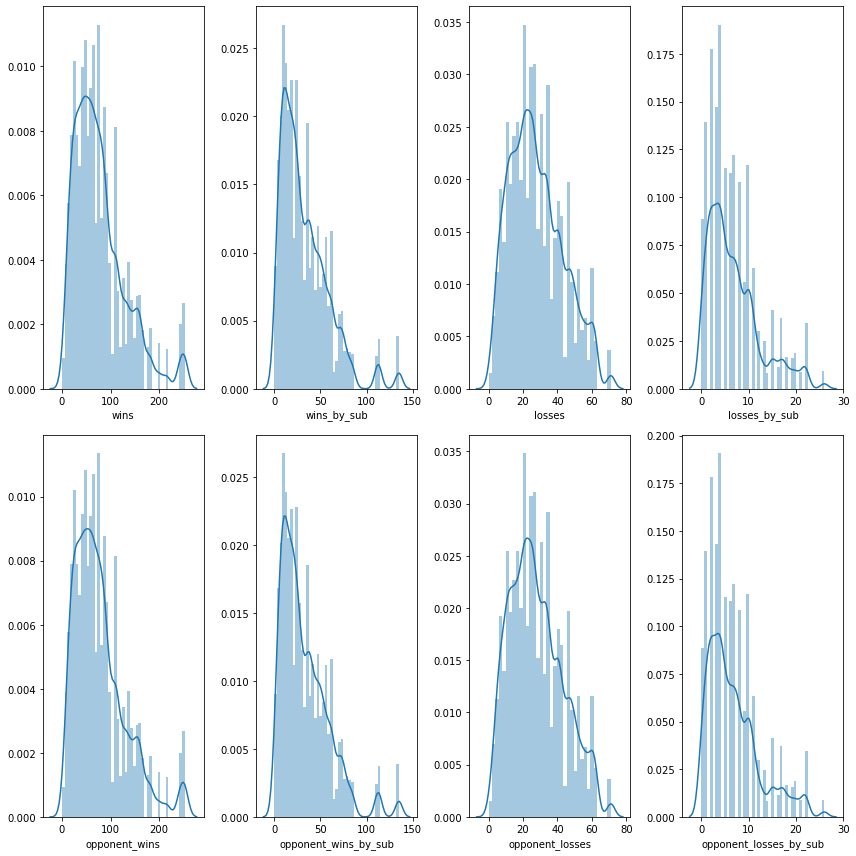

In [7]:
f, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 12))

for i, column in enumerate(df.columns[:8]):
    sns.distplot(df[column], ax=axes[i//4, i%4])

plt.tight_layout()

### Fight history is also right skewed with outliers

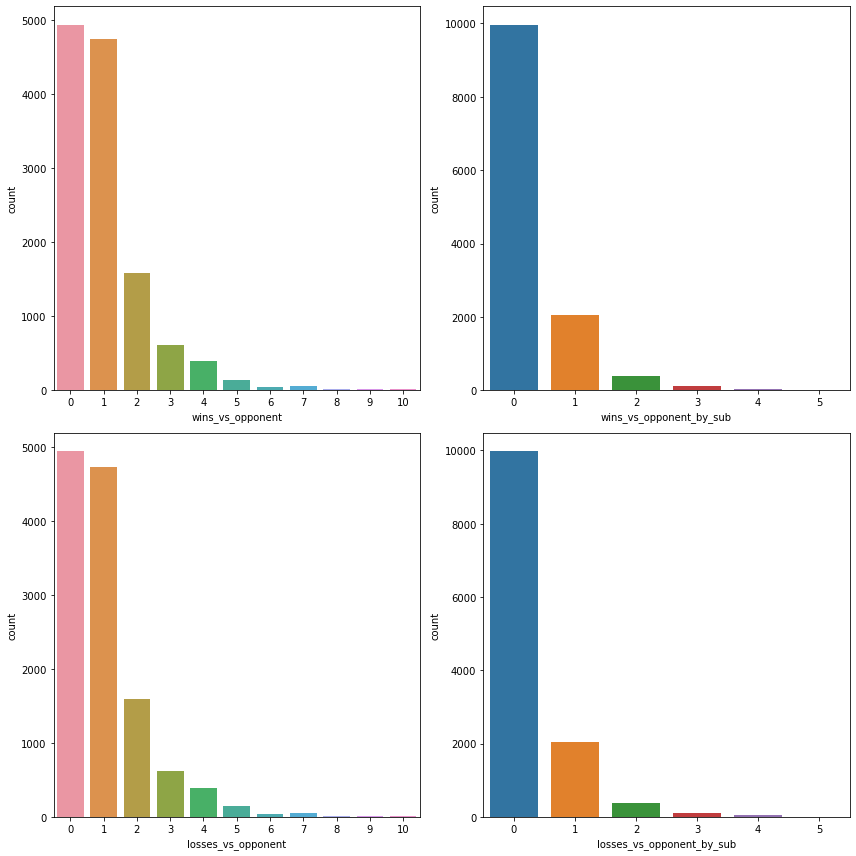

In [8]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for i, column in enumerate(df.columns[8:12]):
    sns.countplot(x=column, data=df, ax=axes[i//2, i%2])

plt.tight_layout()

### Classes are imbalanced

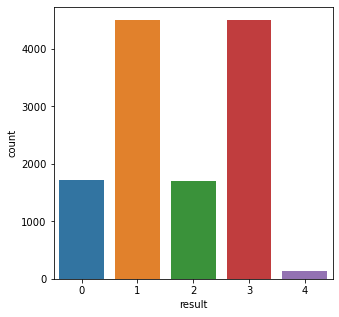

In [9]:
plt.figure(figsize=(5, 5))
sns.countplot(x='result', data=df)

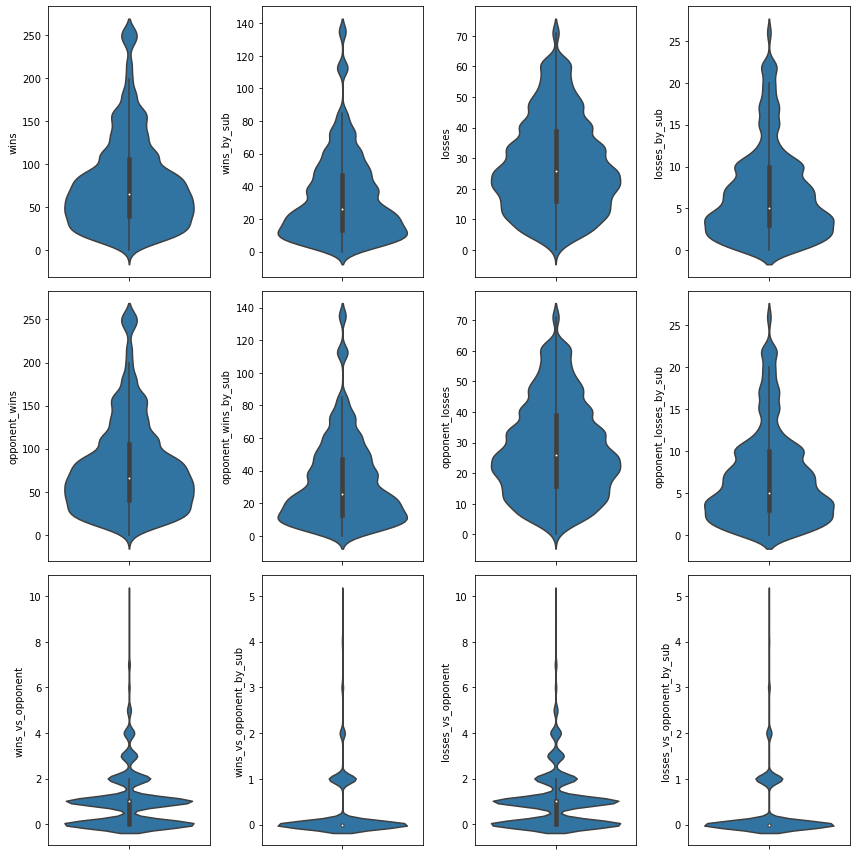

In [10]:
f, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i, column in enumerate(df.columns[:12]):
    sns.violinplot(y=column, data=df, ax=axes[i//4, i%4])

plt.tight_layout()

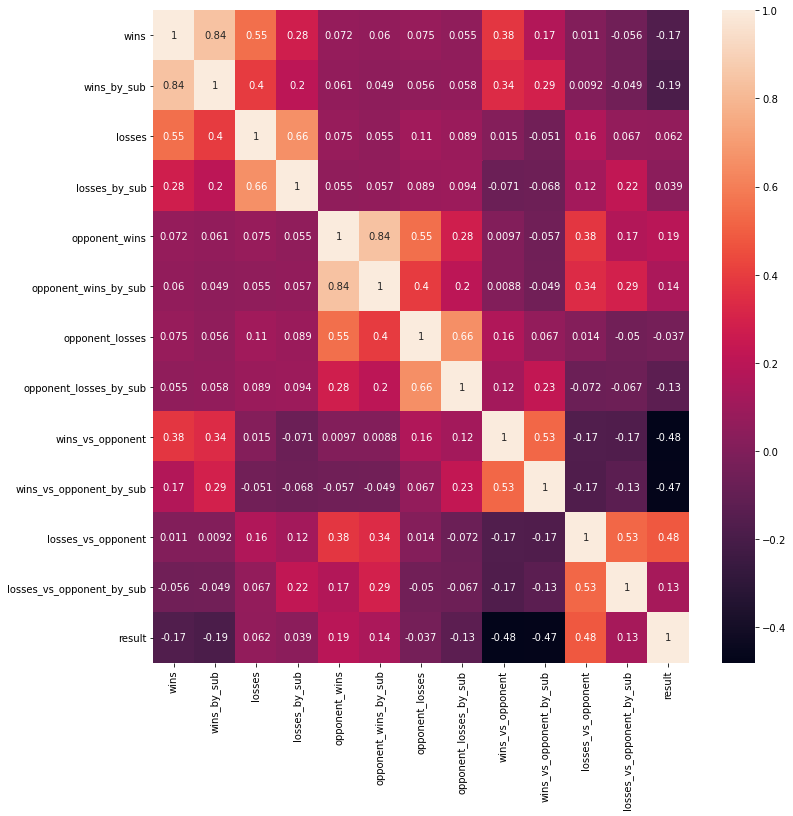

In [11]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True)

###  Wins highly correlated with wins_by_sub (r = 0.84)

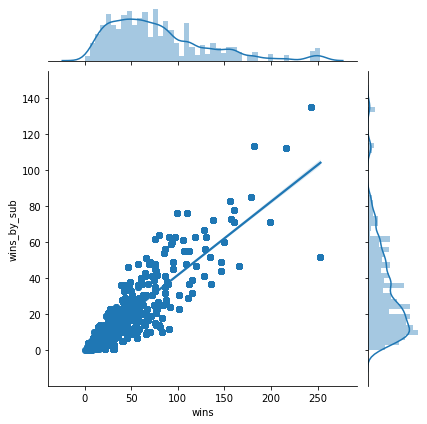

In [12]:
sns.jointplot(x='wins', y='wins_by_sub', kind='regg', data=df)

# Preprocessing

In [13]:
# Drop wins_by_sub because strong positive correlation with wins
df = df.drop(['wins_by_sub', 'opponent_wins_by_sub'], axis=1)

# Drop any row with feature outside of two standard deviations
df = df[(np.abs(stats.zscore(df)) < 2).all(axis=1)]

# Fix imbalanced classes
avg_sub = (df[df['result'] == 0].shape[0] + df[df['result'] == 2].shape[0]) // 2
avg_other = (df[df['result'] == 1].shape[0] + df[df['result'] == 3].shape[0]) // 2
num_drop = avg_other - avg_sub
df = df.drop(df[df['result'] == 1].sample(n=num_drop, random_state=42).index, axis=0)
df = df.drop(df[df['result'] == 3].sample(n=num_drop, random_state=42).index, axis=0)

df.describe()

,wins,losses,losses_by_sub,opponent_wins,opponent_losses,opponent_losses_by_sub,wins_vs_opponent,wins_vs_opponent_by_sub,losses_vs_opponent,losses_vs_opponent_by_sub,result
count,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,62.932413,23.847384,5.804748,63.705426,24.269380,5.823886,0.746851,0.283430,0.742733,0.282219,1.499031
std,40.488117,12.910907,4.147412,40.715284,13.255339,4.155185,0.753710,0.450718,0.743078,0.450134,1.119468
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,14.000000,3.000000,31.000000,14.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,22.000000,5.000000,56.000000,23.000000,5.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,86.000000,33.000000,8.000000,86.000000,33.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3.000000
max,182.000000,57.000000,17.000000,182.000000,57.000000,17.000000,3.000000,1.000000,3.000000,1.000000,3.000000


In [14]:
X_1 = df.iloc[:, :-1]
X_2 = df.iloc[:, :-5]
y = df.iloc[:, -1]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y, test_size=0.1, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, test_size=0.1, random_state=42)

# Standardize
scaler_1 = StandardScaler()
X_train_1 = scaler_1.fit_transform(X_train_1)
X_test_1 = scaler_1.transform(X_test_1)

scaler_2 = StandardScaler()
X_train_2 = scaler_2.fit_transform(X_train_2)
X_test_2 = scaler_2.transform(X_test_2)

# Save scaler
pickle.dump(scaler_1, open('scaler_1.pkl', 'wb'))
pickle.dump(scaler_2, open('scaler_2.pkl', 'wb'))
    
print(X_train_1.shape, X_test_1.shape, y_train_1.shape, y_test_1.shape)
print(X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape)

(3715, 10) (413, 10) (3715,) (413,)
(3715, 6) (413, 6) (3715,) (413,)


# Modeling

In [15]:
def create_model(X_train, X_test, y_train, y_test, model_num):
    def model_builder(hp):
        model = keras.Sequential()
        model.add(keras.layers.InputLayer(input_shape=(X_train.shape[1],)))

        # Tune number of units in first Dense layer
        hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
        hp_reg_1 = hp.Choice('reg_1', values=[1e-1, 1e-2, 1e-3])
        model.add(keras.layers.Dense(units=hp_units_1, activation='relu', kernel_regularizer=keras.regularizers.l2(hp_reg_1)))

        # Tune dropout rate in first Dropout layer
        hp_dropout_1 = hp.Choice('dropout_1', values=[0.25, 0.50, 0.75])
        model.add(keras.layers.Dropout(hp_dropout_1))

        # Tune number of units in second Dense layer
        hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=32)
        hp_reg_2 = hp.Choice('reg_2', values=[1e-1, 1e-2, 1e-3])
        model.add(keras.layers.Dense(units=hp_units_2, activation='relu', kernel_regularizer=keras.regularizers.l2(hp_reg_2)))

        # Tune dropout rate in second Dropout layer
        hp_dropout_2 = hp.Choice('dropout_2', values=[0.25, 0.50, 0.75])
        model.add(keras.layers.Dropout(hp_dropout_2))

        # Output layer
        model.add(keras.layers.Dense(5, activation='softmax'))

        # Tune learning rate
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics = ['accuracy'])

        return model

    tuner = kt.Hyperband(model_builder,
                         objective='val_accuracy',
                         max_epochs=10,
                         factor=3,
                         directory='.',
                         project_name=('tuner_{}'.format(model_num)),
                         overwrite=True)

    class ClearTrainingOutput(keras.callbacks.Callback):
        def on_train_end(*args, **kwargs):
            IPython.display.clear_output(wait = True)

    # Search for the best hyperparameters
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[ClearTrainingOutput()], verbose=2)

    # Retrieve the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Output hyperparameter search results
    print(f"""
    units_1: {best_hps.get('units_1')}
    reg_1: {best_hps.get('reg_1')}
    dropout_1: {best_hps.get('dropout_1')}
    units_2: {best_hps.get('units_2')}
    reg_2: {best_hps.get('reg_2')}
    dropout_2: {best_hps.get('dropout_2')}
    learning_rate: {best_hps.get('learning_rate')}
    """)

    # Build the model using the found hyperparameters and return it
    return tuner.hypermodel.build(best_hps)

In [16]:
# Get model 1 with optimal hyperparamters
model_1 = create_model(X_train_1, X_test_1, y_train_1, y_test_1, '1')

INFO:tensorflow:Oracle triggered exit

    units_1: 224
    reg_1: 0.001
    dropout_1: 0.5
    units_2: 192
    reg_2: 0.001
    dropout_2: 0.5
    learning_rate: 0.01
    


In [17]:
# Train the model
model_1.fit(X_train_1, y_train_1, epochs=10, validation_data=(X_test_1, y_test_1), verbose=2)

# Print accuracies
loss, accuracy = model_1.evaluate(X_test_1, y_test_1, verbose=0)
print('Test Accuracy:', accuracy)
loss, accuracy = model_1.evaluate(X_train_1, y_train_1, verbose=0)
print('Train Accuracy:', accuracy)

Epoch 1/10
117/117 - 0s - loss: 0.6092 - accuracy: 0.8705 - val_loss: 0.3890 - val_accuracy: 0.8983
Epoch 2/10
117/117 - 0s - loss: 0.3960 - accuracy: 0.8966 - val_loss: 0.3294 - val_accuracy: 0.9128
Epoch 3/10
117/117 - 0s - loss: 0.3622 - accuracy: 0.8958 - val_loss: 0.3312 - val_accuracy: 0.8789
Epoch 4/10
117/117 - 0s - loss: 0.3947 - accuracy: 0.8910 - val_loss: 0.3323 - val_accuracy: 0.9177
Epoch 5/10
117/117 - 0s - loss: 0.3664 - accuracy: 0.8999 - val_loss: 0.3743 - val_accuracy: 0.9177
Epoch 6/10
117/117 - 0s - loss: 0.3987 - accuracy: 0.8942 - val_loss: 0.3402 - val_accuracy: 0.9128
Epoch 7/10
117/117 - 0s - loss: 0.3808 - accuracy: 0.8939 - val_loss: 0.3258 - val_accuracy: 0.9225
Epoch 8/10
117/117 - 0s - loss: 0.3763 - accuracy: 0.8913 - val_loss: 0.2982 - val_accuracy: 0.9177
Epoch 9/10
117/117 - 0s - loss: 0.3670 - accuracy: 0.8937 - val_loss: 0.2974 - val_accuracy: 0.9201
Epoch 10/10
117/117 - 0s - loss: 0.3454 - accuracy: 0.9012 - val_loss: 0.3050 - val_accuracy: 0.9007

In [18]:
# Save model 1
model_1.save('model_1.h5')

In [19]:
# Get model 2 with optimal hyperparamters
model_2 = create_model(X_train_2, X_test_2, y_train_2, y_test_2, '2')

INFO:tensorflow:Oracle triggered exit

    units_1: 96
    reg_1: 0.001
    dropout_1: 0.25
    units_2: 256
    reg_2: 0.01
    dropout_2: 0.25
    learning_rate: 0.01
    


In [20]:
# Train the model
model_2.fit(X_train_2, y_train_2, epochs=10, validation_data=(X_test_2, y_test_2), verbose=2)

# Print accuracies
loss, accuracy = model_2.evaluate(X_test_2, y_test_2, verbose=0)
print('Test Accuracy:', accuracy)
loss, accuracy = model_2.evaluate(X_train_2, y_train_2, verbose=0)
print('Train Accuracy:', accuracy)

Epoch 1/10
117/117 - 0s - loss: 1.4786 - accuracy: 0.3631 - val_loss: 1.3481 - val_accuracy: 0.3559
Epoch 2/10
117/117 - 0s - loss: 1.3338 - accuracy: 0.3809 - val_loss: 1.3898 - val_accuracy: 0.3148
Epoch 3/10
117/117 - 0s - loss: 1.3069 - accuracy: 0.3914 - val_loss: 1.3284 - val_accuracy: 0.3971
Epoch 4/10
117/117 - 0s - loss: 1.3165 - accuracy: 0.3817 - val_loss: 1.3797 - val_accuracy: 0.3341
Epoch 5/10
117/117 - 0s - loss: 1.3176 - accuracy: 0.3852 - val_loss: 1.3292 - val_accuracy: 0.3777
Epoch 6/10
117/117 - 0s - loss: 1.3111 - accuracy: 0.3873 - val_loss: 1.3256 - val_accuracy: 0.3705
Epoch 7/10
117/117 - 0s - loss: 1.3034 - accuracy: 0.3949 - val_loss: 1.3251 - val_accuracy: 0.3826
Epoch 8/10
117/117 - 0s - loss: 1.3066 - accuracy: 0.3989 - val_loss: 1.3407 - val_accuracy: 0.3535
Epoch 9/10
117/117 - 0s - loss: 1.3028 - accuracy: 0.3873 - val_loss: 1.3194 - val_accuracy: 0.4068
Epoch 10/10
117/117 - 0s - loss: 1.2971 - accuracy: 0.4000 - val_loss: 1.3231 - val_accuracy: 0.3680

In [21]:
# Save model 2
model_2.save('model_2.h5')

# Sanity Checking

In [22]:
def inverse_pred(pred):
    if pred == 0:
        return 2
    elif pred == 1:
        return 3
    elif pred == 2:
        return 0
    elif pred == 3:
        return 1
    elif pred == 4:
        return 4
    
# Strict means winner is 100% preserved
def reasonable_pred(pred, strict=True):
    if pred == 0:
        return [0, 1]
    elif pred == 1:
        return [0, 1] if strict else [0, 1, 3]
    elif pred == 2:
        return [2, 3]
    elif pred == 3:
        return [2, 3] if strict else [1, 2, 3]
    elif pred == 4:
        return [4] if strict else [1, 3, 4]

def sanity_check(check_data, scaler, model, is_model_1, strict=True):
    # Split check data into X and y
    X_check = []
    y_check = []
    for X, y in check_data:
        X_check.append(X)
        y_check.append(y)
    X_check = np.array(X_check)
    
    # Scale input
    X_check = scaler.transform(X_check)

    # Invert input to check symmetry
    X_check_inv = []
    for arr in X_check:
        arr = arr.tolist()
        if is_model_1:
            X_check_inv.append(arr[3:6] + arr[:3] + arr[8:] + arr[6:8])
        else:
            X_check_inv.append(arr[3:] + arr[:3])
    X_check_inv = np.array(X_check_inv)
    
    # Get predictions
    preds = np.argmax(model.predict(X_check), axis=1)
    preds_inv = np.argmax(model.predict(X_check_inv), axis=1)
    
    # Evaluate accuracy
    correct = [(y in reasonable_pred(pred, strict) and y in reasonable_pred(inverse_pred(pred_inv), strict))
               for y, pred, pred_inv in zip(y_check, preds, preds_inv)]
    num_correct = sum(correct)
    
    # Output results
    print('y_check:   {}'.format(np.array(y_check)))
    print('preds:     {}'.format(preds))
    print('preds_inv: {}'.format(preds_inv))
    print('correct:   {}'.format(np.multiply(correct, 1)))
    print('accuracy:  {}/{}, {:.1f}%'.format(num_correct, len(correct), 100 * num_correct / len(correct)))


In [23]:
check_data = [
    [[80, 5, 1, 182, 34, 3, 2, 2, 0, 0], 0],
    [[80, 5, 1, 65, 53, 21, 2, 2, 1, 0], 0],
    [[80, 5, 1, 130, 19, 5, 0, 0, 2, 1], 3],
    [[80, 5, 1, 253, 35, 9, 0, 0, 1, 0], 3],
    [[80, 5, 1, 69, 25, 4, 1, 1, 0, 0], 0],
    [[253, 35, 9, 138, 14, 4, 0, 0, 4, 0], 3],
    [[253, 35, 9, 160, 42, 6, 0, 0, 1, 0], 3],
    [[253, 35, 9, 97, 11, 1, 0, 0, 2, 2], 2],
    [[253, 35, 9, 130, 19, 5, 1, 0, 0, 0], 1],
    [[253, 35, 9, 182, 34, 3, 7, 0, 1, 0], 1],
    [[34, 6, 2, 40, 13, 4, 1, 0, 0, 0], 1],
    [[34, 6, 2, 27, 6, 2, 1, 0, 0, 0], 1],
    [[34, 6, 2, 28, 13, 2, 5, 1, 0, 0], 1],
    [[34, 6, 2, 2, 1, 0, 0, 0, 1, 1], 2],
    [[34, 6, 2, 57, 26, 3, 2, 0, 0, 0], 1]
]
scaler_1 = pickle.load(open('scaler_1.pkl', 'rb'))
model_1 = keras.models.load_model('model_1.h5')
sanity_check(check_data=check_data, scaler=scaler_1, model=model_1, is_model_1=True, strict=True)

y_check:   [0 0 3 3 0 3 3 2 1 1 1 1 1 2 1]
preds:     [0 0 2 3 0 3 3 2 1 1 1 1 1 2 1]
preds_inv: [2 2 0 1 2 1 1 0 3 3 3 3 3 0 3]
correct:   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
accuracy:  15/15, 100.0%


In [24]:
check_data = [
    [[76, 7, 0, 65, 53, 21], 0],
    [[76, 7, 0, 22, 10, 2], 0],
    [[76, 7, 0, 40, 25, 10], 0],
    [[76, 7, 0, 80, 5, 1], 3],
    [[76, 7, 0, 182, 34, 3], 3],
    [[253, 35, 9, 65, 53, 21], 0],
    [[253, 35, 9, 22, 10, 2], 0],
    [[253, 35, 9, 40, 25, 10], 0],
    [[253, 35, 9, 80, 5, 1], 0],
    [[253, 35, 9, 182, 34, 3], 1],
    [[10, 0, 0, 65, 53, 21], 2],
    [[10, 0, 0, 22, 10, 2], 3],
    [[10, 0, 0, 40, 25, 10], 2],
    [[10, 0, 0, 80, 5, 1], 2],
    [[10, 0, 0, 182, 34, 3], 2]
]
scaler_2 = pickle.load(open('scaler_2.pkl', 'rb'))
model_2 = keras.models.load_model('model_2.h5')
sanity_check(check_data=check_data, scaler=scaler_2, model=model_2, is_model_1=False, strict=True)

y_check:   [0 0 0 3 3 0 0 0 0 1 2 3 2 2 2]
preds:     [0 0 0 1 3 0 0 0 0 3 0 0 0 2 2]
preds_inv: [2 2 2 1 1 2 2 2 2 3 2 0 2 0 0]
correct:   [1 1 1 0 1 1 1 1 1 0 0 0 0 1 1]
accuracy:  10/15, 66.7%
